In [ ]:
# default_exp inferno

In [ ]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# INFERNO loss

Attempted reproduction INFERNO following TF1 & TF2 implementations with exact effect of nuisances being passed through model
Runs but doesn't reproduce paper results

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
from pytorch_inferno.model_wrapper import ModelWrapper
from pytorch_inferno.callback import *
from pytorch_inferno.data import get_paper_data
from pytorch_inferno.plotting import *
from pytorch_inferno.inference import *
from pytorch_inferno.utils import *

from fastcore.all import partialler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from typing import *
from collections import OrderedDict
from fastcore.all import store_attr
from abc import abstractmethod

import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torch
from torch import Tensor
from torch import autograd

# Network

In [ ]:
bs = 2000
data, test = get_paper_data(200000, bs=bs, n_test=1000000)

In [ ]:
# export
class VariableSoftmax(nn.Softmax):
    r'''Softmax with temperature'''
    def __init__(self, temp:float=1, dim:int=-1):
        super().__init__(dim=dim)
        self.temp = temp
        
    def forward(self, x:Tensor) -> Tensor: return super().forward(x/self.temp)

In [ ]:
x = torch.randn((1,10))

In [ ]:
VariableSoftmax(0.1)(x), VariableSoftmax(0.5)(x), VariableSoftmax(1)(x)

(tensor([[1.1082e-07, 3.1861e-15, 2.8409e-10, 3.5593e-09, 1.2945e-15, 1.7134e-06,
          2.9645e-13, 3.9618e-07, 9.2305e-09, 1.0000e+00]]),
 tensor([[0.0331, 0.0010, 0.0100, 0.0167, 0.0009, 0.0573, 0.0025, 0.0428, 0.0202,
          0.8155]]),
 tensor([[0.0904, 0.0159, 0.0498, 0.0641, 0.0145, 0.1188, 0.0250, 0.1027, 0.0705,
          0.4483]]))

In [ ]:
net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,10), VariableSoftmax(0.1))
init_net(net)

# Loss

In [ ]:
x,y,w = next(iter(data.trn_dl))
preds = net(x)
assert preds.shape == (bs,10)

In [ ]:
def to_shape(p:Tensor) -> Tensor:
    f = p.sum(0)
    f = f/f.sum()
    return f

In [ ]:
m = y.squeeze()==0
f_s = to_shape(preds[~m])
f_b = to_shape(preds[m])

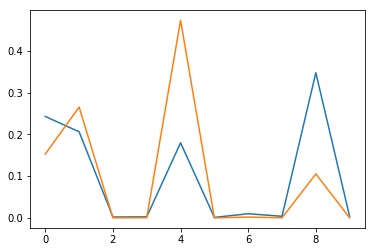

In [ ]:
plt.plot(to_np(f_s))
plt.plot(to_np(f_b))

In [ ]:
class AbsInferno(AbsCallback):
    r'''Attempted reproduction of TF1 & TF2 INFERNO with exact effect of nuisances being passed through model
    Runs but doesn't reproduce paper results; values are off and display strong changes between benchmarks
    Includes option to randomise params per batch, but results in worse performance'''
    def __init__(self, n:int, true_mu:float, n_alphas:int=0, aug_alpha:bool=False):
        super().__init__()
        store_attr()
        self.true_b = self.n-self.true_mu
        
    def on_train_begin(self) -> None:
        self.wrapper.loss_func = None  # Ensure loss function is skipped, callback computes loss value in `on_forwards_end`
        for c in self.wrapper.cbs:
            if hasattr(c, 'loss_is_meaned'): c.loss_is_meaned = False  # Ensure that average losses are correct
        self.alpha = torch.zeros((self.n_alphas+1), requires_grad=True, device=self.wrapper.device)  #  Nuisances set to zero (true values)
        with torch.no_grad(): self.alpha[0] = self.true_mu  # POI set to true value
                
    def on_batch_begin(self) -> None:
        if self.aug_alpha:
            self.rand = torch.randn_like(self.alpha, device=self.wrapper.device)/10
            with torch.no_grad(): self.alpha += self.rand
        self.wrapper.x = self.aug_data(self.wrapper.x)
    
    def on_batch_end(self) -> None:
        if self.aug_alpha:
             with torch.no_grad(): self.alpha -= self.rand
        self.alpha.grad.data.zero_()
    
    @abstractmethod
    def aug_data(self, x:Tensor) -> Tensor:
        r'''Include nuisances in input data. Overide this for specific problem.'''
        pass
    
    def get_inv_ikk(self, f_s:Tensor, f_b:Tensor) -> Tensor:
        r'''Compute full hessian at true param values'''
        nll = calc_nll(s_exp=self.alpha[0], alpha=self.alpha[1:], s_true=self.true_mu, b_true=self.true_b,
                       f_s=f_s, f_b_nom=f_b, f_b_up=None, f_b_dw=None)
        _,h = calc_grad_hesse(nll, self.alpha, create_graph=True)
        return torch.inverse(h)[0,0]
        
    def on_forwards_end(self) -> None:
        r'''Compute loss and replace wrapper loss value'''
        def to_shape(p:Tensor) -> Tensor:
            f = p.sum(0)+1e-7
            return f/f.sum()
        
        b = self.wrapper.y.squeeze() == 0
        f_s = to_shape(self.wrapper.y_pred[~b])
        f_b = to_shape(self.wrapper.y_pred[b])
        self.wrapper.loss_val = self.get_inv_ikk(f_s=f_s, f_b=f_b)

In [ ]:
class PaperInferno(AbsInferno):
    r'''Inheriting class for dealing with INFERNO paper synthetic problem'''
    def __init__(self, float_r:bool, float_l:bool, l_init:float=3, n:int=1050, true_mu:int=50, aug_alpha:bool=False):
        super().__init__(n=n, true_mu=true_mu, n_alphas=float_r+float_l, aug_alpha=aug_alpha)
        self.float_r,self.float_l,self.l_init = float_r,float_l,l_init
        
    def aug_data(self, x:Tensor) -> Tuple[Tensor,Tensor]:
        i = 1
        if self.float_r:
            x[:,0] += self.alpha[i]
            i += 1
        if self.float_l:
            x[:,2] *= (self.alpha[i]+self.l_init)/self.l_init
        return x

In [ ]:
net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,10), VariableSoftmax(0.1))
init_net(net)
model = ModelWrapper(net)

In [ ]:
%%time
model.fit(200, data=data, opt=partialler(optim.SGD,lr=1e-6), loss=None,
          cbs=[PaperInferno(float_r=True, float_l=True, aug_alpha=False),LossTracker(),SaveBest('weights/best_ie.h5'),EarlyStopping(10)])

1: Train=469.60771606445314 Valid=390.3673492431641
2: Train=371.8573852539063 Valid=365.26965698242185
3: Train=354.760641784668 Valid=354.848076171875
4: Train=346.2562701416016 Valid=348.6852032470703
5: Train=340.3763061523438 Valid=344.0158624267578
6: Train=335.90037048339843 Valid=339.4046337890625
7: Train=330.9622229003906 Valid=331.3229284667969
8: Train=322.05623901367187 Valid=323.19389587402344
9: Train=317.5047277832031 Valid=320.25404235839846
10: Train=314.41311248779294 Valid=317.5123291015625
11: Train=312.64206146240235 Valid=315.5023272705078
12: Train=310.1619137573242 Valid=312.9194665527344
13: Train=308.6147125244141 Valid=311.380625
14: Train=307.15245819091797 Valid=309.8647888183594
15: Train=305.33820587158203 Valid=308.72264404296874
16: Train=303.6976448059082 Valid=306.9981433105469
17: Train=302.367559967041 Valid=305.57737426757814
18: Train=300.7067558288574 Valid=304.02115539550783
19: Train=299.3869625854492 Valid=302.3590899658203
20: Train=298.3993

156: Train=255.15066299438476 Valid=258.3914971923828
157: Train=255.05412506103517 Valid=257.8944073486328
158: Train=254.93697998046875 Valid=257.82126251220706
159: Train=254.91066452026368 Valid=257.6258535766602
160: Train=254.32416229248048 Valid=257.44191284179686
161: Train=253.96725173950196 Valid=257.55077270507815
162: Train=254.15562545776368 Valid=257.20880828857423
163: Train=254.12268249511717 Valid=257.1751272583008
164: Train=254.1091877746582 Valid=256.9677484130859
165: Train=253.48814315795897 Valid=256.7941616821289
166: Train=253.4777296447754 Valid=256.8295254516602
167: Train=253.64358917236328 Valid=256.4196600341797
168: Train=253.44235260009765 Valid=256.5266439819336
169: Train=252.81073669433593 Valid=256.1624645996094
170: Train=252.77882629394531 Valid=256.0538555908203
171: Train=252.59125427246093 Valid=255.9683352661133
172: Train=252.60497085571288 Valid=255.93205963134767
173: Train=252.53767318725585 Valid=255.70891693115234
174: Train=252.694392547

In [ ]:
model.save('weights/Inferno_Test_exact_bm2.h5')

model.load('weights/Inferno_Test_exact_bml1.h5')

# Results

In [ ]:
# export
class InfernoPred(PredHandler):
    r'''Prediction handler for hard assignments'''
    def get_preds(self) -> np.ndarray: return np.argmax(self.preds, 1)

## BM 0

In [ ]:
preds = model._predict_dl(test, pred_cb=InfernoPred())

In [ ]:
df = pd.DataFrame({'pred':preds})
df['gen_target'] = test.dataset.y
df.head()

,pred,gen_target
0,7,1.0
1,2,1.0
2,9,1.0
3,2,1.0
4,4,1.0


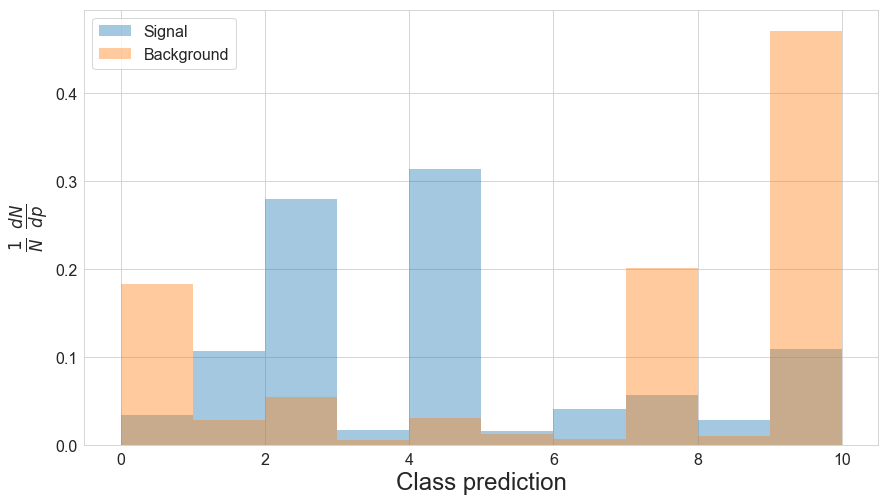

In [ ]:
plot_preds(df, bin_edges=np.linspace(0,10,11))

In [ ]:
bin_preds(df)

In [ ]:
df.head()

,pred,gen_target,pred_bin
0,7,1.0,7
1,2,1.0,2
2,9,1.0,9
3,2,1.0,2
4,4,1.0,4


In [ ]:
f_s,f_b = get_shape(df,1),get_shape(df,0)

In [ ]:
f_s.sum(), f_b.sum()

(tensor(1.), tensor(1.0000))

In [ ]:
f_s, f_b

(tensor([1.4061e-01, 2.7900e-01, 1.6870e-02, 3.1304e-01, 1.5422e-02, 4.1156e-02,
         5.6756e-02, 2.8450e-02, 1.0869e-01, 2.0000e-13]),
 tensor([2.1111e-01, 5.4338e-02, 5.0660e-03, 2.9894e-02, 1.2478e-02, 6.4300e-03,
         2.0047e-01, 9.4640e-03, 4.7075e-01, 2.0000e-13]))

In [ ]:
asimov = (50*f_s)+(1000*f_b)

In [ ]:
asimov, asimov.sum()

(tensor([2.1814e+02, 6.8288e+01, 5.9095e+00, 4.5546e+01, 1.3249e+01, 8.4878e+00,
         2.0331e+02, 1.0887e+01, 4.7618e+02, 2.1000e-10]), tensor(1049.9999))

In [ ]:
n = 1050
x = np.linspace(20,80,61)
y = np.zeros_like(x)
for i,m in enumerate(x):
    pois = torch.distributions.Poisson((m*f_s)+(1000*f_b))
    y[i] = -pois.log_prob(asimov).sum()
y

array([27.12079239, 26.98727608, 26.86009789, 26.73749352, 26.62004852,
       26.50817299, 26.40122604, 26.29944992, 26.20263672, 26.11065483,
       26.02316475, 25.94112587, 25.8635025 , 25.79052353, 25.72197914,
       25.65804863, 25.59888268, 25.5440197 , 25.49322701, 25.44704819,
       25.40494919, 25.36747742, 25.33388138, 25.30456161, 25.27893448,
       25.25754166, 25.24060059, 25.22680664, 25.21738815, 25.2114563 ,
       25.20986557, 25.21156311, 25.2172699 , 25.22623062, 25.23939896,
       25.25595093, 25.27590561, 25.29957581, 25.3265419 , 25.35696411,
       25.39142227, 25.42871094, 25.46940994, 25.51313782, 25.56066513,
       25.61106873, 25.66469574, 25.72165298, 25.78167343, 25.84511185,
       25.91159058, 25.9803772 , 26.05277634, 26.12837982, 26.20697021,
       26.28799057, 26.37255096, 26.45932007, 26.54909134, 26.64221573,
       26.73767471])

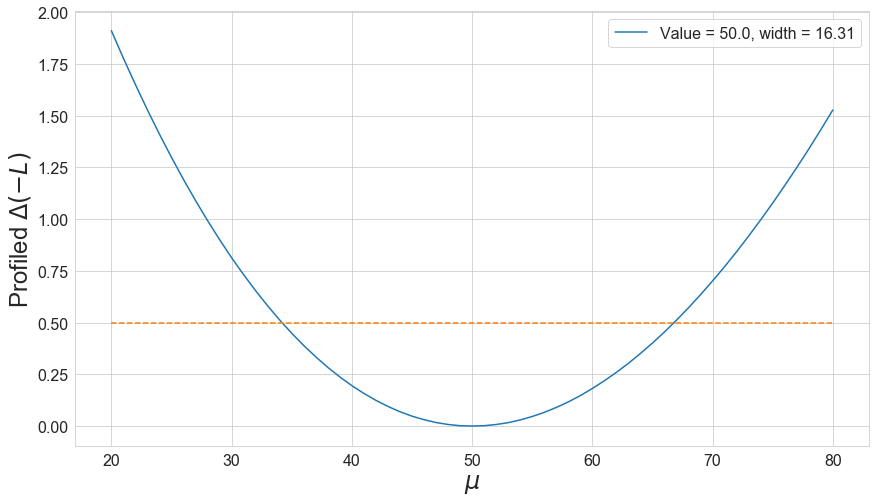

In [ ]:
plot_likelihood(y-y.min())

# Nuisances - via interpolation

In [ ]:
bkg = test.dataset.x[test.dataset.y.squeeze() == 0]
assert len(bkg) == 500000

In [ ]:
b_shapes = get_paper_syst_shapes(bkg, df, model=model, pred_cb=InfernoPred())

Running: r=-0.2


Running: r=0


Running: r=0.2


Running: l=2.5


Running: l=3


Running: l=3.5


In [ ]:
df

,pred,gen_target,pred_bin,pred_-0.2_3,pred_-0.2_3_bin,pred_0_3,pred_0_3_bin,pred_0.2_3,pred_0.2_3_bin,pred_0_2.5,pred_0_2.5_bin,pred_0_3.5,pred_0_3.5_bin
0,7,1.0,7,7,7,7,7,7,7,7,7,7,7
1,2,1.0,2,2,2,2,2,2,2,2,2,2,2
2,9,1.0,9,9,9,9,9,9,9,9,9,9,9
3,2,1.0,2,2,2,2,2,2,2,2,2,2,2
4,4,1.0,4,4,4,4,4,4,4,4,4,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,9,0.0,9,9,9,9,9,9,9,9,9,9,9
999996,0,0.0,0,0,0,0,0,0,0,0,0,0,0
999997,9,0.0,9,9,9,9,9,9,9,9,9,9,9
999998,9,0.0,9,9,9,9,9,9,9,9,9,9,9


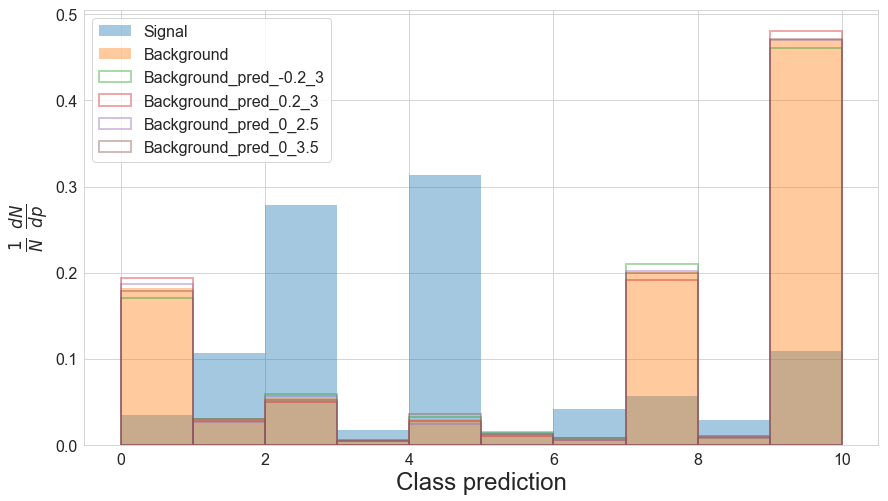

In [ ]:
plot_preds(df, pred_names=['pred', 'pred_-0.2_3', 'pred_0.2_3', 'pred_0_2.5', 'pred_0_3.5'], bin_edges=np.linspace(0,10,11))

tensor([2.0335e-01, 6.1104e-02, 6.5940e-03, 2.6100e-02, 1.5516e-02, 6.3840e-03,
        2.1045e-01, 1.1050e-02, 4.5945e-01, 2.0000e-13])
tensor([2.0047e-01, 5.9230e-02, 5.8060e-03, 3.2080e-02, 1.5244e-02, 7.4700e-03,
        2.0941e-01, 9.8400e-03, 4.6044e-01, 2.0000e-13])
tensor([1.9732e-01, 5.7442e-02, 5.1880e-03, 3.8168e-02, 1.5014e-02, 8.4340e-03,
        2.0854e-01, 8.8340e-03, 4.6105e-01, 2.0000e-13])
tensor([2.1399e-01, 5.6212e-02, 5.8540e-03, 2.3914e-02, 1.2750e-02, 5.3440e-03,
        2.0151e-01, 1.0674e-02, 4.6976e-01, 2.0000e-13])
tensor([2.1111e-01, 5.4338e-02, 5.0660e-03, 2.9894e-02, 1.2478e-02, 6.4300e-03,
        2.0047e-01, 9.4640e-03, 4.7075e-01, 2.0000e-13])
tensor([2.0796e-01, 5.2550e-02, 4.4480e-03, 3.5982e-02, 1.2248e-02, 7.3940e-03,
        1.9960e-01, 8.4580e-03, 4.7136e-01, 2.0000e-13])
tensor([2.2416e-01, 5.1252e-02, 5.3780e-03, 2.1518e-02, 1.0468e-02, 4.4020e-03,
        1.9275e-01, 1.0030e-02, 4.8005e-01, 2.0000e-13])
tensor([2.2128e-01, 4.9378e-02, 4.5900e-0

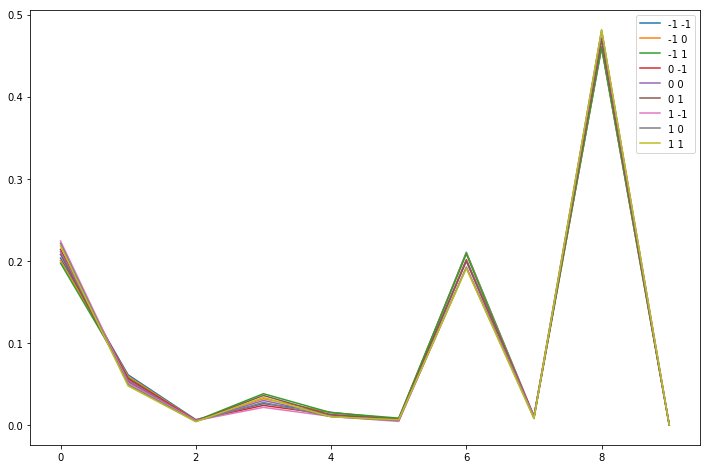

In [ ]:
fig = plt.figure(figsize=(12,8))
for r in [-1,0,1]:
    for l in [-1,0,1]:
        alpha = Tensor((r,l))[None,:]
        s = interp_shape(alpha, **b_shapes).squeeze()
        print(s)
        plt.plot(s, label=f'{r} {l}')
plt.legend()

# Newton

In [ ]:
profiler = partialler(calc_profile, n=1050, mu_scan=torch.linspace(20,80,61), true_mu=50)

## BM 1
r free, l fixed

In [ ]:
bm1_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                            ('f_b_up',  b_shapes['f_b_up'][0][None,:]),
                            ('f_b_dw',  b_shapes['f_b_dw'][0][None,:])])

In [ ]:
bm1_b_shapes['f_b_up'].shape

torch.Size([1, 10])

In [ ]:
nll = profiler(f_s=f_s, n_steps=100, **bm1_b_shapes)

In [ ]:
nll = to_np(nll)

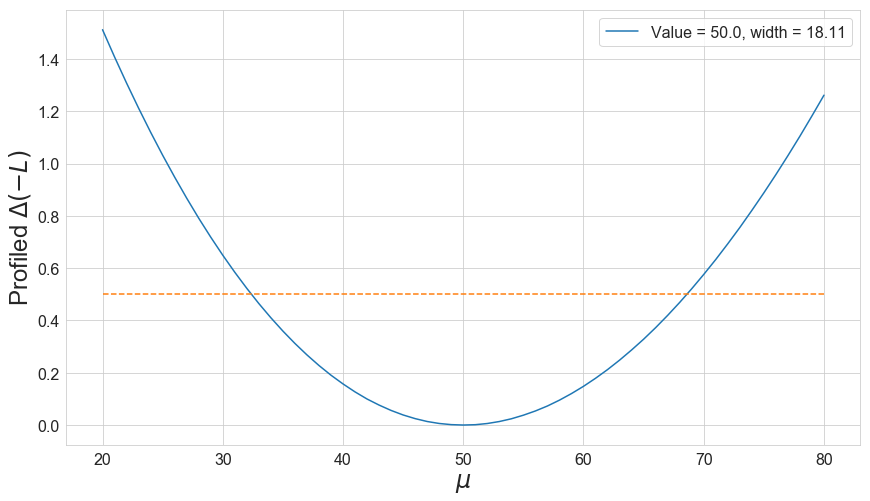

In [ ]:
plot_likelihood(nll-nll.min())

## BM 1l
r fixed, l free

In [ ]:
bm1l_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                             ('f_b_up',  b_shapes['f_b_up'][1][None,:]),
                             ('f_b_dw',  b_shapes['f_b_dw'][1][None,:])])

In [ ]:
nll = profiler(f_s=f_s, n_steps=100, **bm1l_b_shapes)

In [ ]:
nll = to_np(nll)

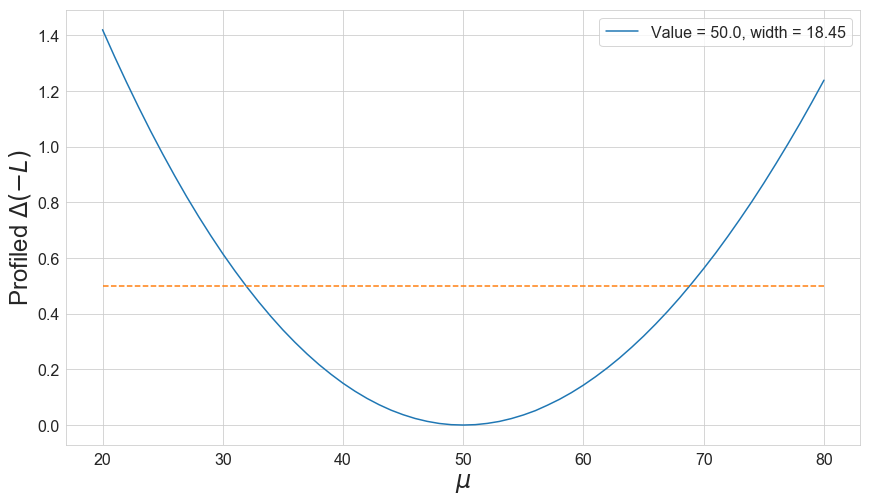

In [ ]:
plot_likelihood(nll-nll.min())

## BM 2

In [ ]:
nll = profiler(f_s=f_s, n_steps=100, **b_shapes)

In [ ]:
nll = to_np(nll)

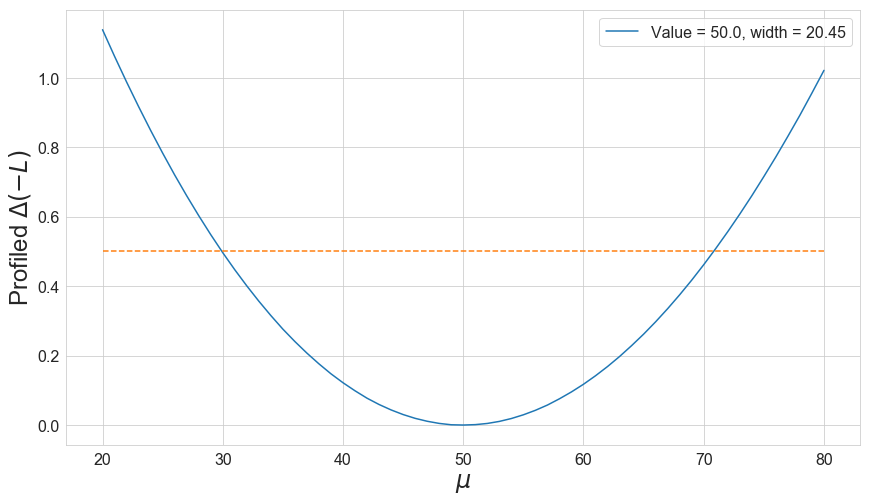

In [ ]:
plot_likelihood(nll-nll.min())